In [1]:
import yaml
import sys
import os
import numpy as np
import torch 
os.chdir('/home/jonfrey/PLR3')
sys.path.insert(0, os.getcwd())
sys.path.append(os.path.join(os.getcwd() + '/src'))
sys.path.append(os.path.join(os.getcwd() + '/lib'))

import loaders_v2
from loaders_v2 import GenericDataset
from rotations import * 

exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_natrix.yml'
env_cfg_path = '/home/jonfrey/PLR3/yaml/env/env_natrix_jonas.yml'

def load_from_file(p):
    if os.path.isfile(p):
        with open(p, 'r') as f:
            data = yaml.safe_load(f)
    else:
        raise ValueError
    return data

exp = load_from_file(exp_cfg_path)
env = load_from_file(env_cfg_path)

dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)

flow_info, inp_get_render, render_res = dataset_train[10450][0] #bann 10450

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

class Drawer():
    def __init__(self):
        self.im_in_plot = 0
        self.data = []
        
    def disp_img_1d(self,img,hold=False, save=False, nr=0):
        self.data.append(img)
        p = '/home/jonfrey/Debug/Midterm2/'
        
        if not hold:
            fig = plt.figure(figsize=(6*2*len(self.data),7))
            ax = []
            for j,a in enumerate(self.data):
                ax.append( fig.add_subplot(1,len(self.data), j+1)  )
                
                ax[-1].get_xaxis().set_visible(False)
                ax[-1].get_yaxis().set_visible(False)
                pos = ax[-1].imshow( a, cmap='Reds' )
                fig.colorbar(pos, ax=ax[-1])
            plt.show()
            if save:
                fig.savefig(p+str(nr)+'.png', dpi=300)
                
            self.data = []
            self.ax = []

h = 480
w = 640

from visu import plot_pcd, Visualizer
import copy
from scipy.spatial.transform import Rotation as R
from helper import re_quat
from PIL import Image, ImageDraw

visu= Drawer()
visualizer = Visualizer(p_visu='home/jonfrey/Debug')   

/home/jonfrey/PLR3/src/helper/bounding_box.py:203: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  masked_idx = (d != 0).nonzero()
/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [2]:
inp_get_render

(array([[[255, 203, 145],
         [251, 188, 130],
         [255, 181,  38],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[255, 196, 112],
         [255, 187, 102],
         [255, 183,  88],
         ...,
         [  1,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[255, 198, 118],
         [249, 176,  96],
         [253, 173,  91],
         ...,
         [  6,   0,   0],
         [  8,   0,  42],
         [  2,   0,  36]],
 
        ...,
 
        [[126,  82,  33],
         [118,  74,  25],
         [119,  68,  42],
         ...,
         [ 27,   8,  28],
         [ 49,  26,   0],
         [ 56,  33,   0]],
 
        [[134,  92,  52],
         [129,  88,  47],
         [129,  81,  52],
         ...,
         [ 43,  24,  30],
         [ 38,  20,   1],
         [ 48,  31,  12]],
 
        [[120,  71,   0],
         [132,  82,   8],
         [126,  79,  31],
         ...,
         [ 25,   0,   7],
  

total 1.5904903411865234


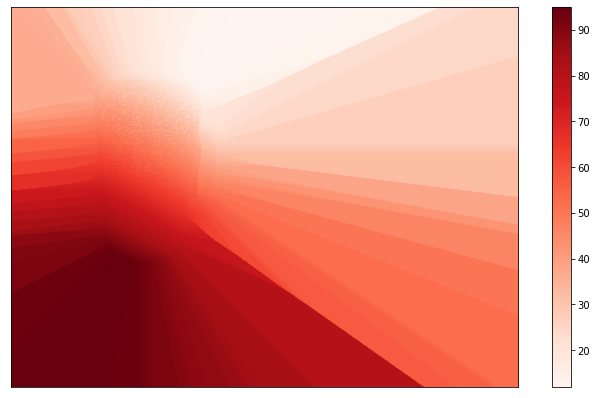

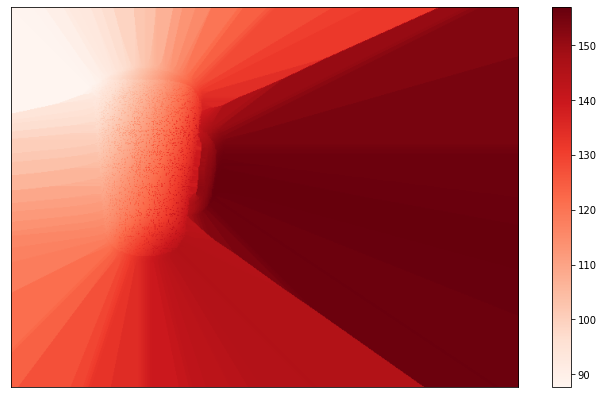

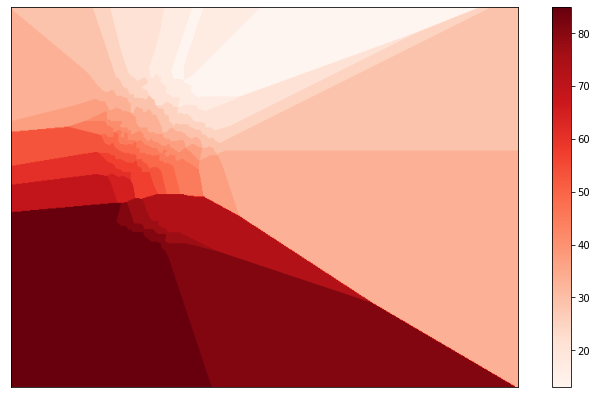

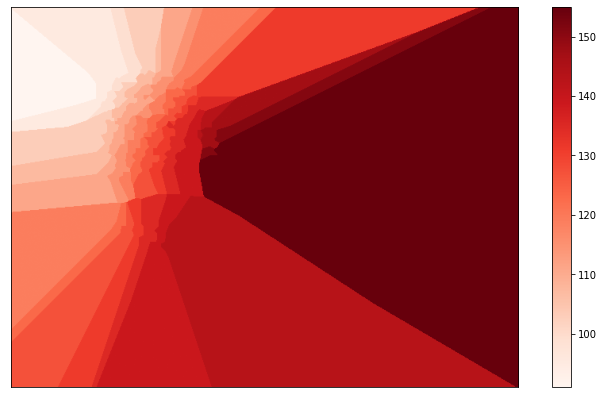

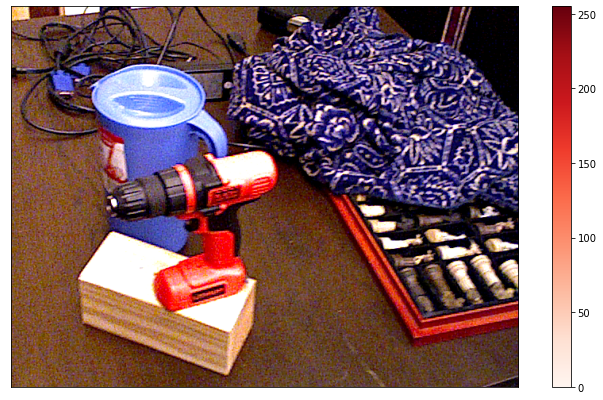

In [41]:
from helper import rotation_angle, re_quat
from torch.autograd import Variable
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.nn as nn
import torch
import time
import random
import numpy as np
import argparse
from scipy.spatial.transform import Rotation as R
from os import path
import numpy.ma as ma
import copy
import scipy.misc
import scipy.io as scio
import torch.utils.data as data
from PIL import Image
import string
import math
import coloredlogs
import logging
import os
import sys
import pickle
import glob
import torchvision
from pathlib import Path


from helper import rotation_angle, re_quat
from visu import plot_pcd, plot_two_pcd
from helper import generate_unique_idx
from loaders_v2 import Backend, ConfigLoader
from helper import flatten_dict, get_bbox_480_640
from deep_im import ViewpointManager
from helper import get_bb_from_depth, get_bb_real_target, backproject_points
from rotations import *

# for flow
import cv2
import trimesh
from trimesh.ray.ray_pyembree import RayMeshIntersector
from scipy.interpolate import griddata
def transform_mesh(mesh, H):
    """ directly operates on mesh and does not create a copy!"""
    t = np.ones((mesh.vertices.shape[0],4)) 
    t[:,:3] = mesh.vertices
    H[:3,:3] = H[:3,:3]
    mesh.vertices = (t @ H.T)[:,:3]
    return mesh

def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """
    #import numpy as np
    #import scipy.ndimage as nd

    if invalid is None: invalid = np.isnan(data)
    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]
def backproject_points_np(p, fx=None, fy=None, cx=None, cy=None, K=None):
    """
    p.shape = (nr_points,xyz)
    """
    if not K is None:
        fx = K[0,0]
        fy = K[1,1]
        cx = K[0,2]
        cy = K[1,2]
    # true_divide
    u = ((p[:, 0] / p[:, 2]) * fx) + cx
    v = ((p[:, 1] / p[:, 2]) * fy) + cy
    return np.stack([v, u]).T  

def _get_flow_test(h_render, h_real, idx, label_img, cam, b_real, b_ren, K_real):
        
        f_1 = label_img == int( idx)
        
        min_vis_size = dataset_train._backend._cfg_d.get('flow_cfg', {}).get('min_vis_size',200)
        if np.sum(f_1) < min_vis_size:
            # to little of the object is visible 
            return False
        m_real = copy.deepcopy(dataset_train._backend._mesh[idx])
        m_real = transform_mesh(m_real, h_real)

        rmi_real = RayMeshIntersector(m_real)
        sub = 1
        tl, br = b_real.limit_bb()

        rays_origin_real = dataset_train._backend._rays_origin_real[cam]  [int(tl[0]): int(br[0]), int(tl[1]): int(br[1])][::sub,::sub]
        rays_dir_real = dataset_train._backend._rays_dir[cam] [int(tl[0]) : int(br[0]), int(tl[1]): int(br[1])][::sub,::sub]
        
        real_locations, real_index_ray, real_res_mesh_id = rmi_real.intersects_location(ray_origins=np.reshape( rays_origin_real, (-1,3) ) , 
            ray_directions=np.reshape(rays_dir_real, (-1,3)))

        
        h_trafo =h_render @ np.linalg.inv( h_real )
        ren_locations = (real_locations @ h_trafo[:3,:3].T) + h_trafo[:3,3]

        uv_ren = backproject_points_np(ren_locations, K=dataset_train._backend.K_ren)
        uv_real =  backproject_points_np(real_locations, K=K_real) 
        dis = uv_ren-uv_real
        
        uv_real = np.uint32(uv_real)
        idx = np.uint32(uv_real[:,0]*(dataset_train._backend._w) + uv_real[:,1]) 
        disparity_pixels = np.zeros((dataset_train._backend._h,dataset_train._backend._w,2))-999
        disparity_pixels = np.reshape( disparity_pixels, (-1,2) )
        disparity_pixels[idx] = dis
        disparity_pixels = np.reshape( disparity_pixels, (dataset_train._backend._h,dataset_train._backend._w,2) )
        
        f_2 = disparity_pixels[:,:,0] != -999
        f_3 = f_2  * f_1
            
        u_map = disparity_pixels[:,:,0]
        v_map = disparity_pixels[:,:,1]
        u_map = fill( u_map, u_map == -999 )
        v_map = fill( v_map, v_map == -999 )
    
        real_tl = np.zeros( (2) )
        real_tl[0] = int(b_real.tl[0])
        real_tl[1] = int(b_real.tl[1])
        real_br = np.zeros( (2) )
        real_br[0] = int(b_real.br[0])
        real_br[1] = int(b_real.br[1])
        ren_tl = np.zeros( (2) )
        ren_tl[0] = int(b_ren.tl[0])
        ren_tl[1] = int(b_ren.tl[1])
        ren_br = np.zeros( (2) )
        ren_br[0] = int( b_ren.br[0] )
        ren_br[1] = int( b_ren.br[1] )
        
        return u_map, v_map, f_3, torch.tensor( real_tl, dtype=torch.int32) , torch.tensor( real_br, dtype=torch.int32) , torch.tensor( ren_tl, dtype=torch.int32) , torch.tensor( ren_br, dtype=torch.int32 ) 

st =time.time()
for i in range(10):
    flow = _get_flow_test( flow_info[0],flow_info[1],flow_info[2],flow_info[3],flow_info[4],flow_info[5],flow_info[6],flow_info[7]   )
print('total', time.time()-st)
Drawer().disp_img_1d(flow[0])
Drawer().disp_img_1d(flow[1])
img, depth_real, label, model_points, obj_idx, K_real, cam_flag, h_gt, h_real_est = inp_get_render
render_img, render_d, real_img, real_d, gt_label_cropped, img_ren, depth_ren, h_render = render_res
# visualizer.plot_estimated_pose(    tag = f"_",
#                                             epoch = 0,
#                                             img= img ,
#                                             points = flow[2],
#                                             K =  K_real ,
#                                             H = np.eye(4),
#                                             method='def',
#                                           jupyter= True)

# visualizer.plot_estimated_pose(    tag = f"_",
#                                             epoch = 0,
#                                             img= img_ren.numpy()[0] ,
#                                             points = flow[3],
#                                             K = dataset_train._backend.K_ren ,
#                                             H = np.eye(4),
#                                             method='def',
#                                           jupyter= True)
flow = dataset_train._backend._get_flow(flow_info[0],flow_info[1],flow_info[2],flow_info[3],flow_info[4],flow_info[5],flow_info[6] )

Drawer().disp_img_1d(flow[0])
Drawer().disp_img_1d(flow[1])
flow_info, inp_get_render, render_res 
Drawer().disp_img_1d( inp_get_render[0] )



In [12]:
from scipy import ndimage

print( type( dataset_train._backend._grid_y) )
# arr = np.stack( [dataset_train._backend._grid_x, dataset_train._backend._grid_y], axis=2)


# # print( [dataset_train._backend._grid_x.tolist(), dataset_train._backend._grid_y.tolist()])

# # print( u_map[u_map != -999].shape )
# # print(u_map.shape)
# # u_map_new = ndimage.map_coordinates(u_map , [[0, 21], [0.5, 1], [0, 21], [0.5, 1]], order=1 )
# # print(u_map_new)
# # Drawer().disp_img_1d(u_map)

# #Drawer().disp_img_1d(u_map_new)

# xy = arr[u_map != -999]
# print(xy.shape)
# data = u_map[u_map != -999]
# print(data.shape)
# from scipy.interpolate import RegularGridInterpolator
# my_interpolating_function = RegularGridInterpolator((xy[:,0],xy[:,1]), data)



<class 'numpy.ndarray'>


In [11]:
from scipy.interpolate import RegularGridInterpolator
def f(x, y, z):
    return 2 * x**3 + 3 * y**2 - z
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)
data = f(*np.meshgrid(x, y, z, indexing='ij', sparse=True))
data.shape

my_interpolating_function = RegularGridInterpolator((x, y, z), data)

pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
my_interpolating_function(pts)


array([125.80469388, 146.30069388])

Time 0.017067909240722656


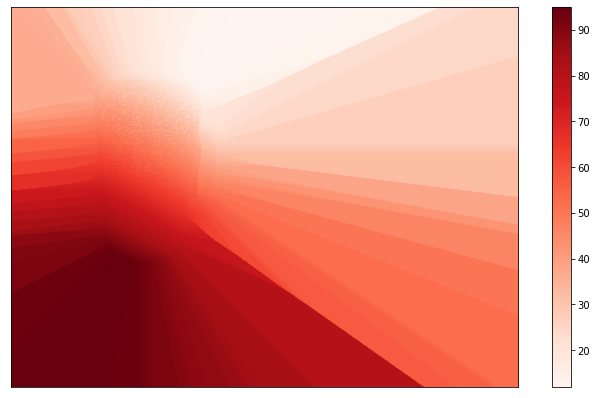

In [29]:
import numpy as np
from scipy import ndimage as nd



def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """
    #import numpy as np
    #import scipy.ndimage as nd

    if invalid is None: invalid = np.isnan(data)
    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]
u_map = flow[0]
np.sum( u_map == -999 )
np.sum( u_map != -999 )
#u_map
st = time.time()
arr = fill( u_map, u_map == -999 )
print('Time', time.time()-st)
Drawer().disp_img_1d(arr)